In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

In [3]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [4]:
try:
    df = pd.read_csv('train.csv')
except FileNotFoundError:
    print("Error: train.csv not found. Please make sure the file is in the same directory.")
    exit()

In [5]:
df_processed = df.copy()

In [6]:
df_processed.drop('Cabin', axis=1, inplace=True)
df_processed['Age'].fillna(df_processed['Age'].median(), inplace=True)
most_frequent_embarked = df_processed['Embarked'].mode()[0]
df_processed['Embarked'].fillna(most_frequent_embarked, inplace=True)

In [7]:
df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1
df_processed['IsAlone'] = 0
df_processed.loc[df_processed['FamilySize'] == 1, 'IsAlone'] = 1
df_processed['Title'] = df_processed['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
title_mapping = {
    "Mr": "Mr", "Miss": "Miss", "Mrs": "Mrs", "Master": "Master",
    "Dr": "Rare", "Rev": "Rare", "Col": "Rare", "Major": "Rare", "Mlle": "Rare",
    "Countess": "Rare", "Ms": "Rare", "Lady": "Rare", "Jonkheer": "Rare",
    "Don": "Rare", "Dona": "Rare", "Mme": "Rare", "Capt": "Rare", "Sir": "Rare"
}
df_processed['Title'] = df_processed['Title'].map(title_mapping)

In [8]:
df_processed.drop(['Name', 'Ticket', 'PassengerId', 'SibSp', 'Parch'], axis=1, inplace=True)

In [9]:
print(df_processed.head())
print(df_processed.info())

   Survived  Pclass     Sex   Age     Fare Embarked  FamilySize  IsAlone Title
0         0       3    male  22.0   7.2500        S           2        0    Mr
1         1       1  female  38.0  71.2833        C           2        0   Mrs
2         1       3  female  26.0   7.9250        S           1        1  Miss
3         1       1  female  35.0  53.1000        S           2        0   Mrs
4         0       3    male  35.0   8.0500        S           1        1    Mr
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   Fare        891 non-null    float64
 5   Embarked    891 non-null    object 
 6   FamilySize  891 non-null    int64  
 7   IsAlone     891 non-null    int64  
 8   Title  

In [11]:
# Define age bins and labels
bins = [0, 12, 18, 60, np.inf] # Children, Teenagers, Adults, Elderly
labels = ['Child', 'Teenager', 'Adult', 'Elderly']

In [12]:
df_processed['AgeGroup']=pd.cut(df_processed['Age'], bins=bins, labels=labels, right=False)
print(df_processed['AgeGroup'].value_counts())

AgeGroup
Adult       752
Child        68
Teenager     45
Elderly      26
Name: count, dtype: int64


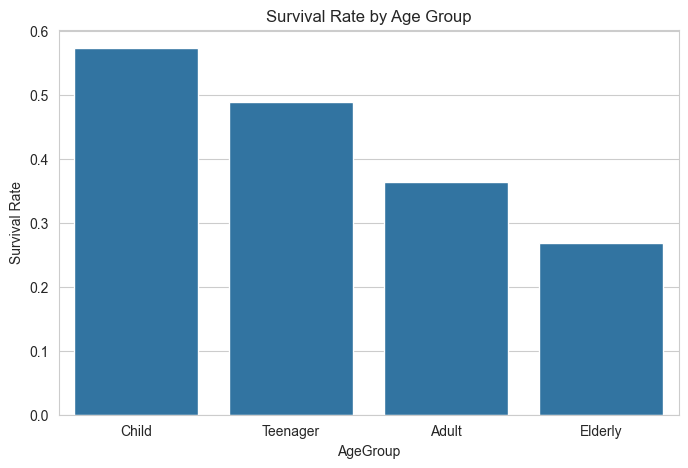

In [13]:
plt.figure(figsize=(8, 5))
sns.barplot(x='AgeGroup', y='Survived', data=df_processed, errorbar=None, order=labels)
plt.title('Survival Rate by Age Group')
plt.ylabel('Survival Rate')
plt.show()

In [14]:
df_processed['FareBand']=pd.qcut(df_processed['Fare'],4,labels=['Very Low','Low','Medium','High'])
print(df_processed['FareBand'].value_counts())

FareBand
Low         224
Very Low    223
Medium      222
High        222
Name: count, dtype: int64


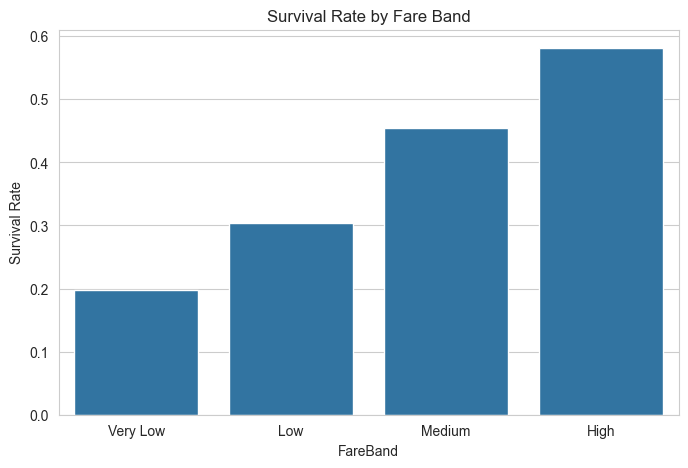

In [15]:
plt.figure(figsize=(8, 5))
sns.barplot(x='FareBand', y='Survived', data=df_processed, errorbar=None)
plt.title('Survival Rate by Fare Band')
plt.ylabel('Survival Rate')
plt.show()

In [16]:
df_processed['Pclass_Sex']=df_processed['Pclass'].astype(str)+'_'+df_processed['Sex']
print(df_processed['Pclass_Sex'].value_counts())

Pclass_Sex
3_male      347
3_female    144
1_male      122
2_male      108
1_female     94
2_female     76
Name: count, dtype: int64


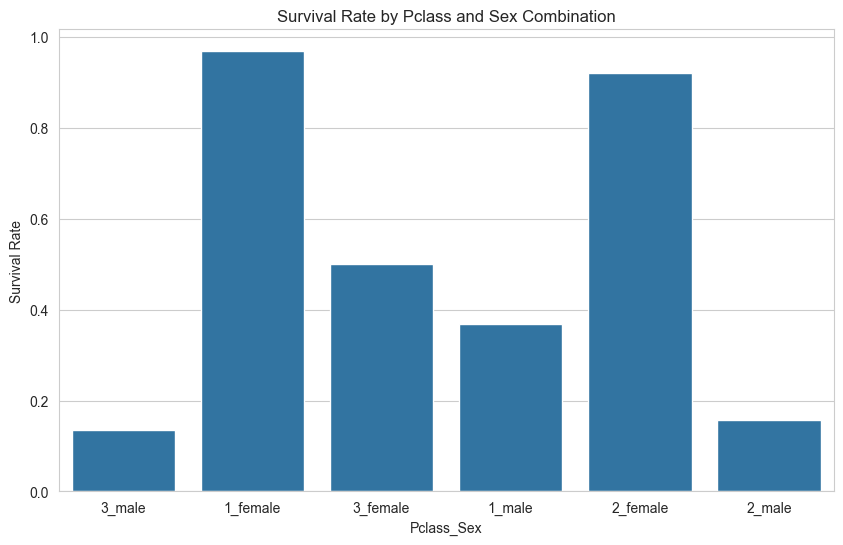

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Pclass_Sex', y='Survived', data=df_processed, errorbar=None)
plt.title('Survival Rate by Pclass and Sex Combination')
plt.ylabel('Survival Rate')
plt.show()

In [18]:
df_processed.drop(['Age', 'Fare'], axis=1, inplace=True)

In [19]:
print(df_processed.head())
print(df_processed.info())

   Survived  Pclass     Sex Embarked  FamilySize  IsAlone Title AgeGroup  \
0         0       3    male        S           2        0    Mr    Adult   
1         1       1  female        C           2        0   Mrs    Adult   
2         1       3  female        S           1        1  Miss    Adult   
3         1       1  female        S           2        0   Mrs    Adult   
4         0       3    male        S           1        1    Mr    Adult   

   FareBand Pclass_Sex  
0  Very Low     3_male  
1      High   1_female  
2       Low   3_female  
3      High   1_female  
4       Low     3_male  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Sex         891 non-null    object  
 3   Embarked    891 non-null    object  
 4   FamilySize  891 non-null    int

In [20]:
categorical_cols_final = ['Sex', 'Embarked', 'Pclass', 'Title', 'AgeGroup', 'FareBand', 'Pclass_Sex']
df_final_encoded = pd.get_dummies(df_processed, columns=categorical_cols_final, drop_first=True)

In [21]:
print("DataFrame after all one-hot encoding:")
print(df_final_encoded.head())
print("\nShape after all one-hot encoding:", df_final_encoded.shape)

DataFrame after all one-hot encoding:
   Survived  FamilySize  IsAlone  Sex_male  Embarked_Q  Embarked_S  Pclass_2  \
0         0           2        0      True       False        True     False   
1         1           2        0     False       False       False     False   
2         1           1        1     False       False        True     False   
3         1           2        0     False       False        True     False   
4         0           1        1      True       False        True     False   

   Pclass_3  Title_Miss  Title_Mr  ...  AgeGroup_Adult  AgeGroup_Elderly  \
0      True       False      True  ...            True             False   
1     False       False     False  ...            True             False   
2      True        True     False  ...            True             False   
3     False       False     False  ...            True             False   
4      True       False      True  ...            True             False   

   FareBand_Low  FareBan

In [23]:
numerical_cols_to_scale_final = ['FamilySize']
scaler_final = StandardScaler()
df_final_encoded[numerical_cols_to_scale_final] = scaler_final.fit_transform(df_final_encoded[numerical_cols_to_scale_final])

In [24]:
print("\nDataFrame after final numerical feature scaling:")
print(df_final_encoded.head())


DataFrame after final numerical feature scaling:
   Survived  FamilySize  IsAlone  Sex_male  Embarked_Q  Embarked_S  Pclass_2  \
0         0    0.059160        0      True       False        True     False   
1         1    0.059160        0     False       False       False     False   
2         1   -0.560975        1     False       False        True     False   
3         1    0.059160        0     False       False        True     False   
4         0   -0.560975        1      True       False        True     False   

   Pclass_3  Title_Miss  Title_Mr  ...  AgeGroup_Adult  AgeGroup_Elderly  \
0      True       False      True  ...            True             False   
1     False       False     False  ...            True             False   
2      True        True     False  ...            True             False   
3     False       False     False  ...            True             False   
4      True       False      True  ...            True             False   

   FareBand_

In [25]:
X_adv = df_final_encoded.drop('Survived', axis=1)
y_adv = df_final_encoded['Survived']


In [26]:
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(X_adv, y_adv, test_size=0.2, random_state=42, stratify=y_adv)

In [27]:
model_adv = LogisticRegression(random_state=42)
print("Training the Logistic Regression model with advanced features...")
model_adv.fit(X_train_adv, y_train_adv)
print("Model training complete.")

Training the Logistic Regression model with advanced features...
Model training complete.


In [28]:
print("\n--- Model Evaluation with Advanced Features ---")

y_pred_adv = model_adv.predict(X_test_adv)
y_pred_proba_adv = model_adv.predict_proba(X_test_adv)[:, 1]

accuracy_adv = accuracy_score(y_test_adv, y_pred_adv)
conf_matrix_adv = confusion_matrix(y_test_adv, y_pred_adv)
class_report_adv = classification_report(y_test_adv, y_pred_adv)
fpr_adv, tpr_adv, thresholds_adv = roc_curve(y_test_adv, y_pred_proba_adv)
roc_auc_adv = auc(fpr_adv, tpr_adv)

print(f"\nAccuracy (Advanced Features): {accuracy_adv:.4f}")
print("\nConfusion Matrix (Advanced Features):")
print(conf_matrix_adv)
print("\nClassification Report (Advanced Features):")
print(class_report_adv)
print(f"AUC Score (Advanced Features): {roc_auc_adv:.4f}")



--- Model Evaluation with Advanced Features ---

Accuracy (Advanced Features): 0.8324

Confusion Matrix (Advanced Features):
[[100  10]
 [ 20  49]]

Classification Report (Advanced Features):
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       110
           1       0.83      0.71      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

AUC Score (Advanced Features): 0.8636


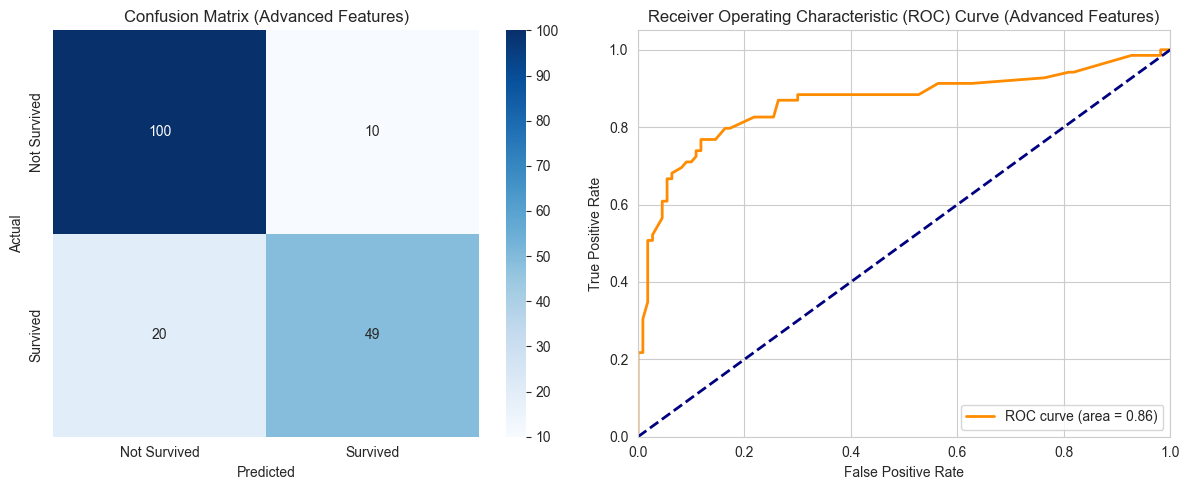

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_adv, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Advanced Features)')

plt.subplot(1, 2, 2)
plt.plot(fpr_adv, tpr_adv, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_adv:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Advanced Features)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [30]:
print(f"Original Model Accuracy (approx): 0.8100") # Replace with actual if you run previous code
print(f"Advanced Model Accuracy: {accuracy_adv:.4f}")
print(f"Original Model AUC (approx): 0.8500") # Replace with actual if you run previous code
print(f"Advanced Model AUC: {roc_auc_adv:.4f}")

Original Model Accuracy (approx): 0.8100
Advanced Model Accuracy: 0.8324
Original Model AUC (approx): 0.8500
Advanced Model AUC: 0.8636
